# 라이브러리 import

In [94]:
# 필요 라이브러리 import
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.font_manager as fm
import seaborn as sns

from konlpy.tag import Okt
from collections import Counter
import re

from itertools import combinations
from collections import defaultdict
import networkx as nx 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from kneed import KneeLocator

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

import requests
import pprint
import json

# 형태소 분석

In [2]:
# 데이터가 존재할 경우 CSV 파일을 읽어 DataFrame으로 변환
if os.path.exists('./data/crawled_data.csv'):
    # CSV 파일을 읽어 DataFrame으로 변환
    with open('./data/crawled_data.csv', 'r', encoding='utf-8') as f:
        contents = pd.read_csv(f)

In [3]:
# 데이터 확인
contents['content'][0]

'오늘 아이돌봄 서비스를 처음 이용했습니다오후6시에서 오후9시까지 봐주셨습니다\u200b여아 5세아이 6시하원도와주시고 집에서 저녁식사 챙겨주셨어요아이 식사도 챙겨주시고 같이 그림도 그려주신게 너무 좋았는데요퇴근후 집에서 뵐때 아이 밥 차려주면서 본인 저녁식사도 같이 하셨다고 하시더라구요\u200b미리 말안해주셔서 살짝 당황스럽긴 했는데요  돌봄 선생님 말로는 원래 다 그렇게 같이 차려먹는다고 하시고 간식이나 과일도 같이 먹는다고 하시네요다른 카페글은 각자 챙겨오신다고 하네요..\u200b고기나 야채 사두면 알아서 국이나 반찬 요리해서 아이랑 먹겠다고 하시는데 원래 이렇게 진행되는게 맞을까요?\u200b다른 돌봄 선생님들도 다 똑같다고 하셔서..혹시 선배맘님들 아이돌봄 서비스 이용하실때 어떻게 이용하세요? 궁금합니당 ㅠㅠ\u200b\u200b\u200b\u200b\u200b\u200b\u200b🧡천안.아산의 모든정보와 살아가는 이야기가 모여있는 온라인 커뮤니티 [천안아산줌마렐라]'

In [4]:
# 결측치로 표기한 데이터의 shape 확인
display(contents[contents['title'] == '제목 없음'].shape)
display(contents[contents['content'] == '내용 없음'].shape)
display(contents[contents['reply'] == '댓글 없음'].shape)

(1220, 4)

(1556, 4)

(1513, 4)

In [6]:
# 데이터 버전 유지
contents_ver1 = contents.copy()
# 해당 데이터를 사용하고 싶으면 아래 주석을 해제
del contents_ver1

# 데이터 결측치 제거
contents = contents[~(contents.isin(['제목 없음', '내용 없음', '댓글 없음']).any(axis=1))]

# 데이터 확인
display(contents)

,url,title,content,reply
0,https://cafe.naver.com/no1cheonan?iframe_url=%...,아이돌봄서비스 돌봄선생님 바꾸는게 나을까요?,오늘 아이돌봄 서비스를 처음 이용했습니다오후6시에서 오후9시까지 봐주셨습니다​여아 ...,https://cafe.naver.com/no1cheonan/3792095닉네임 규...
1,https://cafe.naver.com/malltail?iframe_url=%2F...,정부 아이돌봄서비스~ 애들 아침밥이요!!,출근시간이 빨라서정부 아이돌봄서비스 신청했다가드디어 연락이와서 담주부터 이용하기로 ...,아침 먹이시던걸로 준비 해 놓으면 되지요
2,https://cafe.naver.com/seoulhanbumo?iframe_url...,아이돌봄서비스 이용중 너무 속상하네요 ㅠ,신세한탄할곳이 이곳뿐이라 여기에 남겨요. 저 같은 고민하시는 분 있을까요?아이는 만...,토닥토닥 그돌봄쌤들이 인성이 아직 성숙하지 못한 분들이시네요 이럴수록 더 아무렇...
3,https://cafe.naver.com/imsanbu?iframe_url=%2FA...,아이돌봄서비스 vs 시간제보육,​6개월 여아 키우고 있어요.남편은 일주일에 하루만 쉬고요.그동안은 외출 거의 안하...,그래도 아시는분께 맡기는게 좋지 않을까요?? ㅠㅠ
4,https://cafe.naver.com/cafe1535?iframe_url=%2F...,아이돌봄서비스,"- 가구원수 = 명- 부양의무자 =- 재산(금융&일반,부동산) = 만원- 소득(양육...",픽업해서 엄마가 준비한 음식 데워주고 책읽어주기 까지만 되어요. 아이먹은 설거지만 ...
...,...,...,...,...
2832,https://cafe.naver.com/skydevelopers?iframe_ur...,맞벌이 시터 세팅,"올해 첫 아이를 낳고, 출산휴가만 쓰고 복직 예정입니다.입주 시터를 쓰려고 했는데 ...",영유아어린이집 대기했다가 보냈어요
2834,https://cafe.naver.com/loveloveloveovelove?ifr...,시터,활발한 남자 1살 아긴데 릴리안 시터괜찮겠죠??,안녕하세요? 혹시 시터 카톡아이디 공유 가능하실까요?
2861,https://cafe.naver.com/dgmom365?iframe_url=%2F...,15분정도만 봐주는 등원시터도 있나요? 어디서 알아보고 비용은 어느정도 드나요?,제가 드뎌 취뽀해서 다다음주부터 출근을 하게 됐어요근데 문제는 대중교통 기준 1시간...,아이돌봄서비스로 되려나요?보건소에서 본거같은데...시급으로 계산하실꺼에요..
2862,https://cafe.naver.com/cebu100x?iframe_url=%2F...,시터없이 제이파크 잘 놀았어요,"📢 제목에 지역과 [세부,보홀,보라카이] 숙소명 풀네임으로 꼭 넣어주세요​​아직 막...",이런후기감사해요~ 대부분 시터후기가있으니 세부가면 다 시터써야되나? 이런생각인분...


In [7]:
def okt_func(df, tag):
    # 크롤링한 전체 글 모음
    texts = df[tag].tolist()

    # None/NaN 제거 + 전부 str 타입으로 변환
    texts = [str(t) for t in texts if pd.notnull(t)]

    text = ' '.join(texts)

    # 간단한 정제 (이모지/특수문자 제거)
    text = re.sub(r'[^가-힣\s]', '', text)

    # 형태소 분석
    okt = Okt()
    nouns = okt.nouns(text)

    # 필터링 한 글자 제외
    filtered = [word for word in nouns if len(word) > 1]

    # 단어 빈도수 계산
    word_count = Counter(filtered)
    
    # 가장 많이 관측되는 단어 50개 출력
    top_words = word_count.most_common(50)
    
    # 계산된 단어 빈도수 DataFrame화
    word_df = pd.DataFrame(word_count.items(), columns=['word', 'count'])

    # 출력
    for word, freq in top_words:
        print(f'[{word}] : {freq}회')

    return word_df

In [9]:
# title 데이터 형태소 분석
title_df = okt_func(contents, 'title')

[서비스] : 416회
[아이돌] : 389회
[이용] : 145회
[베이비] : 74회
[신분] : 67회
[후기] : 55회
[아이] : 48회
[도우미] : 44회
[어플] : 44회
[지원] : 42회
[추천] : 40회
[정부] : 37회
[신청] : 32회
[보신] : 32회
[질문] : 29회
[시간] : 27회
[공유] : 27회
[문의] : 26회
[아기] : 26회
[가요] : 25회
[개월] : 23회
[이모] : 23회
[선생님] : 21회
[시터넷] : 21회
[호텔] : 21회
[가정] : 20회
[펫시터] : 20회
[어린이집] : 19회
[사용] : 19회
[이용권] : 19회
[하이] : 18회
[열람] : 18회
[하원] : 14회
[관련] : 14회
[육아] : 13회
[구인] : 13회
[파크] : 13회
[여행] : 13회
[시간제] : 12회
[혹시] : 12회
[구해] : 12회
[방법] : 11회
[하나요] : 11회
[시급] : 11회
[업체] : 11회
[제이] : 11회
[세부] : 11회
[파주] : 11회
[아시] : 10회
[등원] : 10회


In [ ]:
# content 데이터 형태소 분석0
content_df = okt_func(contents, 'content')

[아이] : 1449회
[서비스] : 1132회
[시간] : 885회
[이용] : 739회
[아기] : 576회
[신청] : 561회
[아이돌] : 532회
[정도] : 412회
[지원] : 370회
[선생님] : 347회
[사용] : 347회
[카톡] : 299회
[생각] : 296회
[개월] : 290회
[정부] : 286회
[가정] : 278회
[혹시] : 251회
[엄마] : 239회
[어린이집] : 231회
[사람] : 226회
[저희] : 220회
[하루] : 210회
[센터] : 204회
[예약] : 198회
[하이] : 192회
[베이비] : 189회
[정말] : 188회
[이모] : 188회
[경우] : 186회
[후기] : 186회
[다른] : 179회
[남편] : 171회
[아동] : 171회
[둘째] : 171회
[도우미] : 171회
[작업] : 171회
[그냥] : 170회
[추천] : 166회
[케어] : 164회
[우리] : 164회
[도움] : 164회
[확인] : 162회
[걱정] : 161회
[하원] : 160회
[연락] : 158회
[바로] : 156회
[지금] : 156회
[재생] : 156회
[업체] : 155회
[계속] : 153회


In [ ]:
# reply 데이터 형태소 분석
reply_df = okt_func(contents, 'reply')

[아이] : 167회
[신청] : 161회
[시간] : 138회
[이용] : 133회
[선생님] : 108회
[서비스] : 87회
[센터] : 61회
[연락] : 56회
[아이돌] : 54회
[지원] : 50회
[어린이집] : 45회
[아기] : 45회
[정도] : 44회
[대기] : 42회
[저희] : 42회
[정부] : 41회
[매칭] : 40회
[등업] : 40회
[생각] : 38회
[지금] : 38회
[혹시] : 37회
[사람] : 36회
[확인] : 36회
[개월] : 34회
[이모] : 32회
[하이] : 32회
[추천] : 32회
[바로] : 31회
[정보] : 31회
[엄마] : 30회
[문의] : 30회
[정말] : 29회
[하원] : 28회
[지역] : 28회
[진짜] : 28회
[어플] : 28회
[보고] : 27회
[면접] : 27회
[질문] : 27회
[소득] : 26회
[업체] : 26회
[후기] : 26회
[도우미] : 26회
[상담] : 25회
[다른] : 25회
[미리] : 24회
[한번] : 24회
[경우] : 23회
[주민] : 23회
[게시판] : 23회


In [12]:
# 형태소 분석 결과를 DataFrame으로 변환
df_lst = [content_df, title_df, reply_df]

for df in df_lst:
    display(df)

,word,count
0,오늘,129
1,아이돌,532
2,서비스,1132
3,처음,124
4,이용,739
...,...,...
8745,알로,1
8746,정크푸드,1
8747,향연,1
8748,맨질,1


,word,count
0,아이돌,389
1,서비스,416
2,선생님,21
3,정부,37
4,아침밥,2
...,...,...
1027,계획,1
1028,공덕,1
1029,애오개,1
1030,세팅,1


,word,count
0,닉네임,3
1,규정,1
2,변경,9
3,다미,1
4,통보,1
...,...,...
2110,대부분,1
2111,인분,1
2112,아이어,1
2113,커서,1


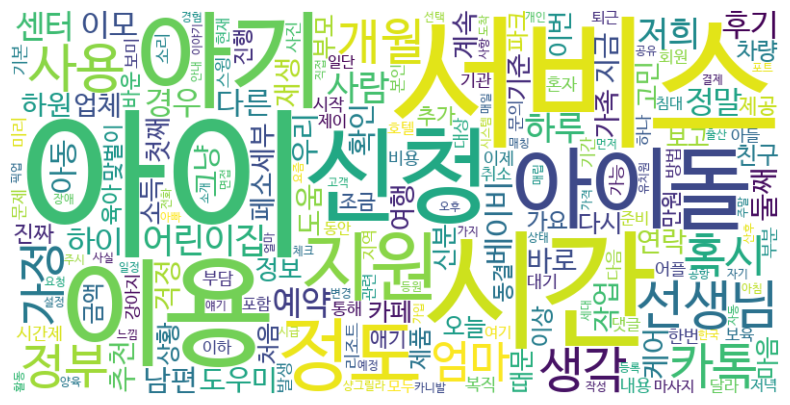

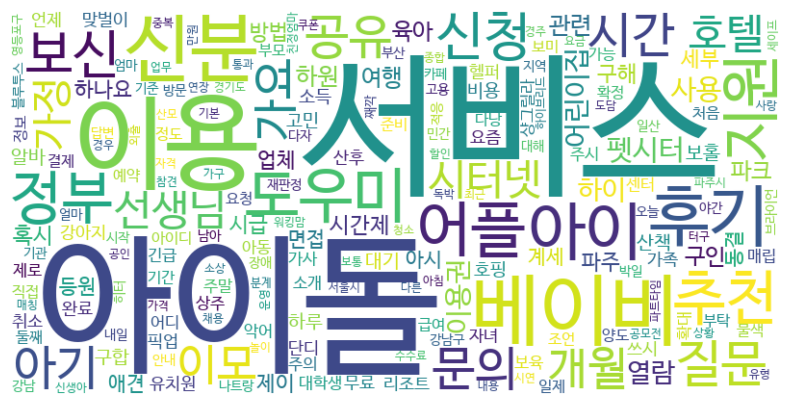

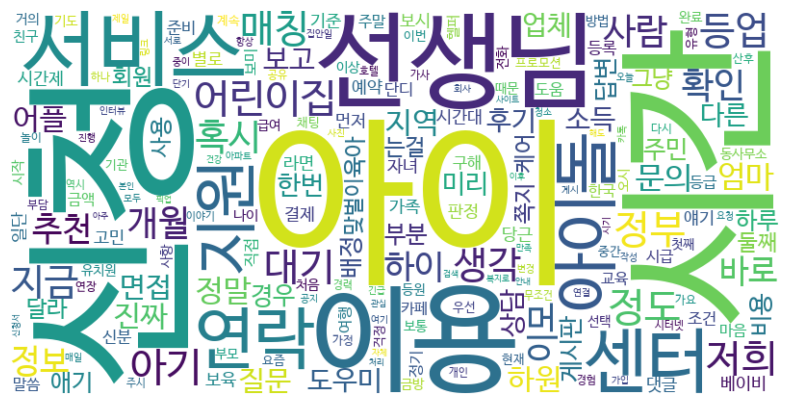

In [13]:
# 1. 폰트 경로 설정 (NanumBarunGothic 기준)
# font_path = fm.findfont('NanumBarunGothic')  # 시스템에 설치된 폰트 자동 탐색
# 또는 수동 지정 예시:
font_path = 'C:/Windows/Fonts/NanumBarunGothic.ttf'

# 2. matplotlib에도 한글 폰트 설정 (혹시 모를 깨짐 방지)
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

for df in df_lst:
    # 워드 클라우드 생성
    wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(df['word'], df['count'])))

    # 시각화
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# 전처리 및 병합된 데이터를 통한 다양한 분석

In [112]:
# 데이터 불러오기
family_society_data = pd.read_csv('./notion_data/family_society_real_final.csv', encoding='utf-8')
family_society_data = family_society_data.drop(labels='연도', axis=1).groupby('행정구역').mean().reset_index()

# 데이터 확인
display(family_society_data.head())

,행정구역,출생아수,교육기관수,어린이집수,초등학교수,영유아_인구수,아동_인구수,가구수,인구수,육아휴직(부),육아휴직(모)
0,강원특별자치도,7490.000000,5.000000,362.666667,348.000000,53369.000000,86309.333333,6.735540e+05,1.451376e+06,306.000000,1826.000000
1,경기도,76399.666667,5.666667,2196.666667,1311.666667,573996.000000,924719.000000,5.265352e+06,1.282443e+07,2558.666667,20366.000000
2,경상남도,15467.333333,1.000000,684.000000,508.000000,125342.000000,222270.333333,1.373915e+06,3.130337e+06,492.333333,3560.333333
3,경상북도,12076.333333,9.000000,693.000000,473.000000,92041.000000,151792.333333,1.151590e+06,2.471656e+06,397.000000,2731.333333
4,광주광역시,7573.333333,1.333333,293.333333,155.000000,57843.666667,100183.000000,6.127207e+05,1.406072e+06,261.666667,2153.000000


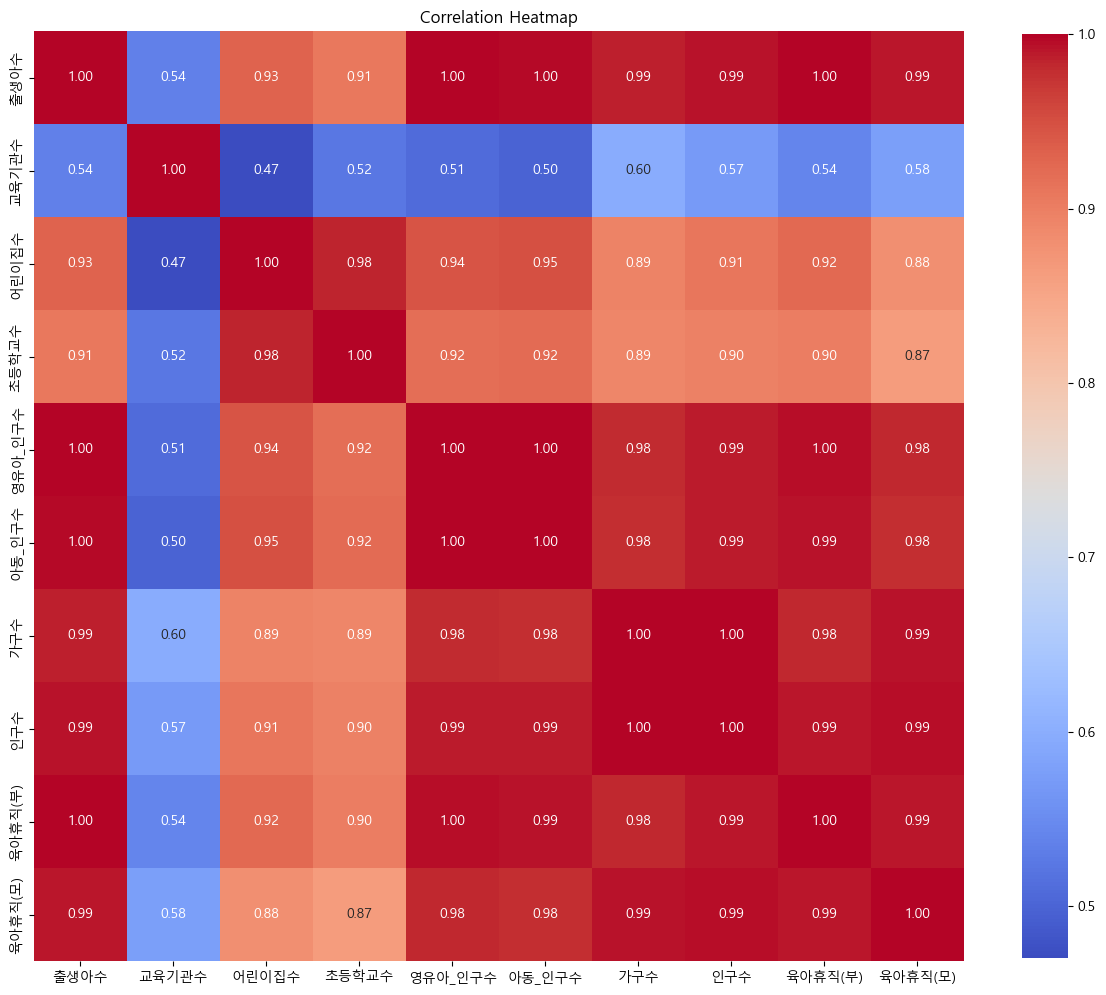

In [114]:
# 각 데이터의 피어슨 상관계수 확인
family_society_data_numeric = family_society_data.select_dtypes(include=[np.number])

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

plt.figure(figsize=(15, 15))
plt.title('Correlation Heatmap')
sns.heatmap(family_society_data_numeric.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.show()

## 클러스터링 전 차원 축소를 통한 데이터 전처리

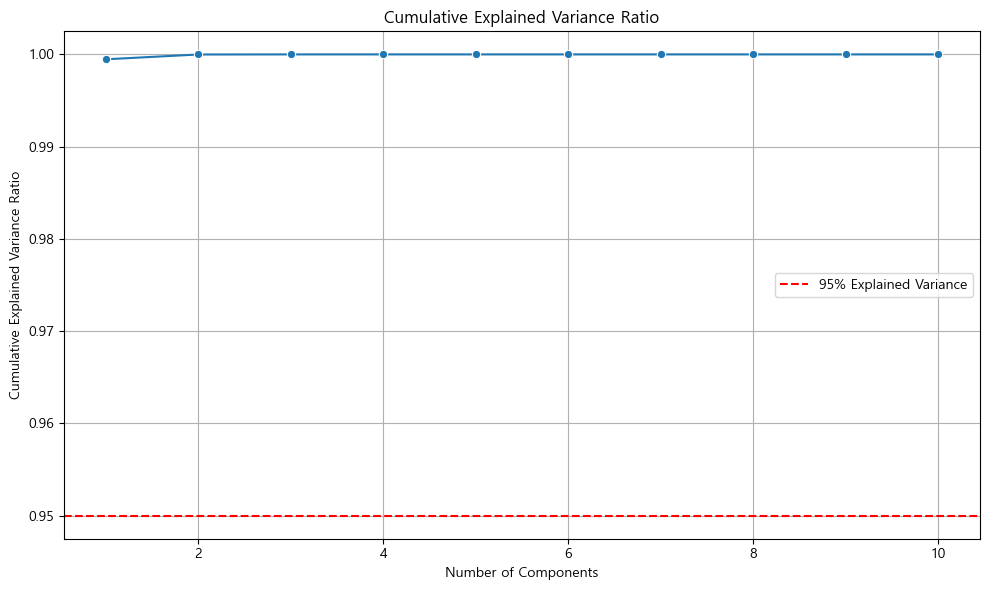

95% 설명하는 데 필요한 주성분 수: 1


In [115]:
# 1. 전체 PCA 먼저 fit
pca = PCA()
pca.fit(family_society_data_numeric)

# 2. 누적 설명 분산 비율 계산
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 3. 그래프 그리기
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(cumulative_variance) + 1), y=cumulative_variance, marker="o")

# 4. 95% 선 추가
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 5. 그리고 95% 넘는 컴포넌트 수도 구할 수 있어
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"95% 설명하는 데 필요한 주성분 수: {n_components_95}")

95%를 설명하는데 필요한 주성분의 수는 1개이지만, 그래프 시각화를 위해 2개로 조정하여 PCA 적용

In [116]:
# PCA 변환
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(family_society_data_numeric)

# PCA 결과를 DataFrame으로 변환
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# 데이터 확인
display(pca_df.head())

,PC1,PC2
0,-1.549797e+06,16463.277737
1,1.075358e+07,-175569.277313
2,2.757248e+05,2414.491416
3,-4.214709e+05,59122.737365
4,-1.613912e+06,-26366.226267


## 클러스터링

In [117]:
# 데이터 스케일링
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_df)

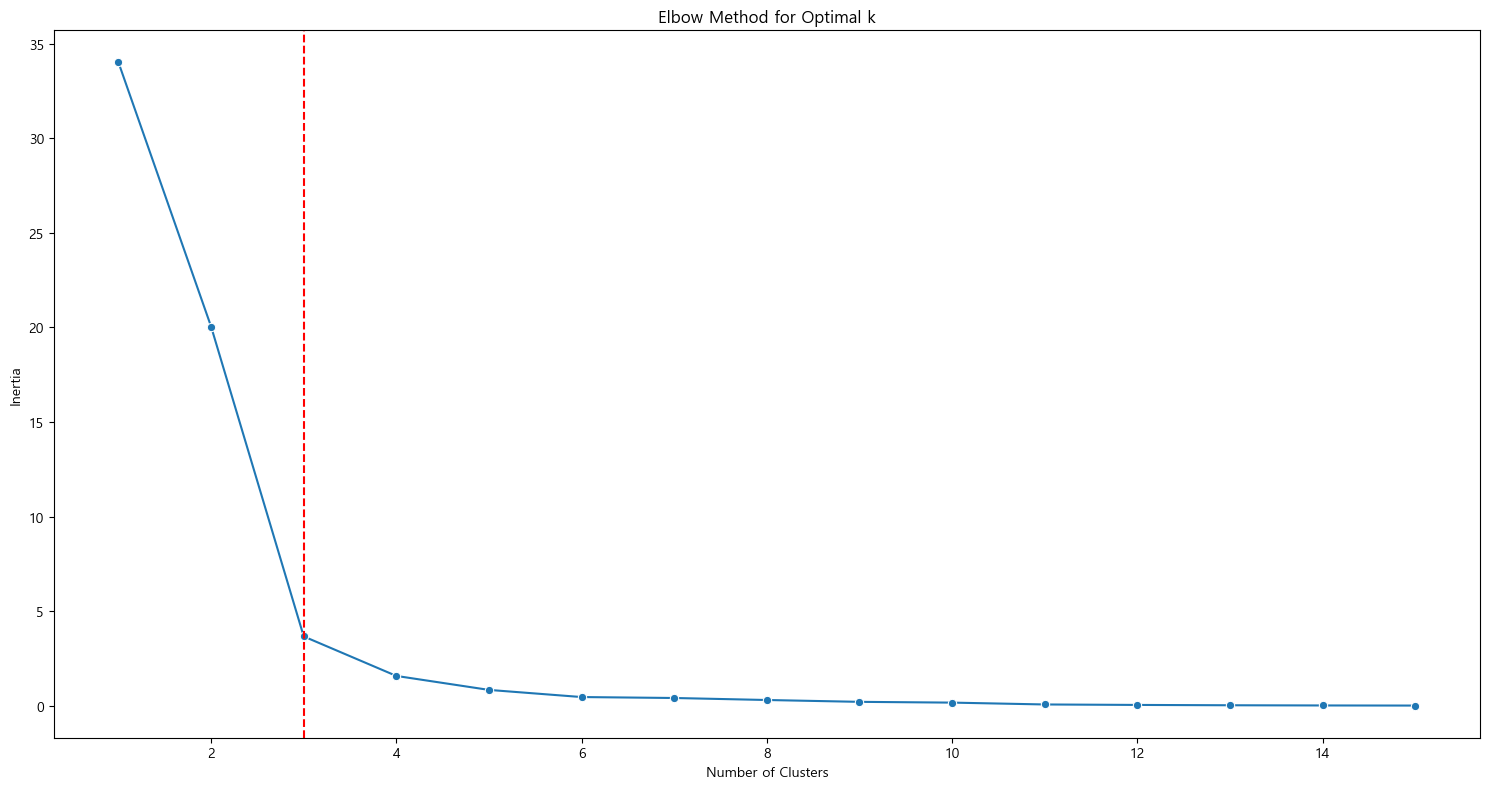

In [118]:
# Elbow method을 사용하여 최적의 클러스터 개수 찾기
inertia_list = []

for k in range(1, 16):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia_list.append(kmeans.inertia_)

kneedle = KneeLocator(range(1, 16), inertia_list, curve='convex', direction='decreasing')

plt.figure(figsize=(15, 8))
sns.lineplot(x=range(1, 16), y=inertia_list, marker='o')
plt.axvline(x=kneedle.elbow, color='r', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()

군집이 3개로 나뉘는 것을 확인했으므로, k=3으로 설정

In [139]:
cluster = 5

,출생아수,교육기관수,어린이집수,초등학교수,영유아_인구수,아동_인구수,가구수,인구수,육아휴직(부),육아휴직(모)
Cluster,,,,,,,,,,
0,9565.166667,2.125000,436.583333,344.208333,73739.708333,125530.541667,8.544010e+05,1.900627e+06,336.000000,2365.000000
1,45192.666667,10.000000,790.000000,607.666667,309840.333333,491929.000000,4.042636e+06,9.016711e+06,1537.666667,14995.000000
2,76399.666667,5.666667,2196.666667,1311.666667,573996.000000,924719.000000,5.265352e+06,1.282443e+07,2558.666667,20366.000000
3,7191.800000,1.266667,214.400000,139.333333,54649.666667,90635.266667,5.320063e+05,1.256364e+06,281.333333,1898.533333
4,13311.166667,5.000000,545.500000,388.500000,102563.166667,169264.000000,1.289833e+06,2.832163e+06,440.000000,3423.500000


Silhouette Score: 0.449
Davies-Bouldin Score: 0.393


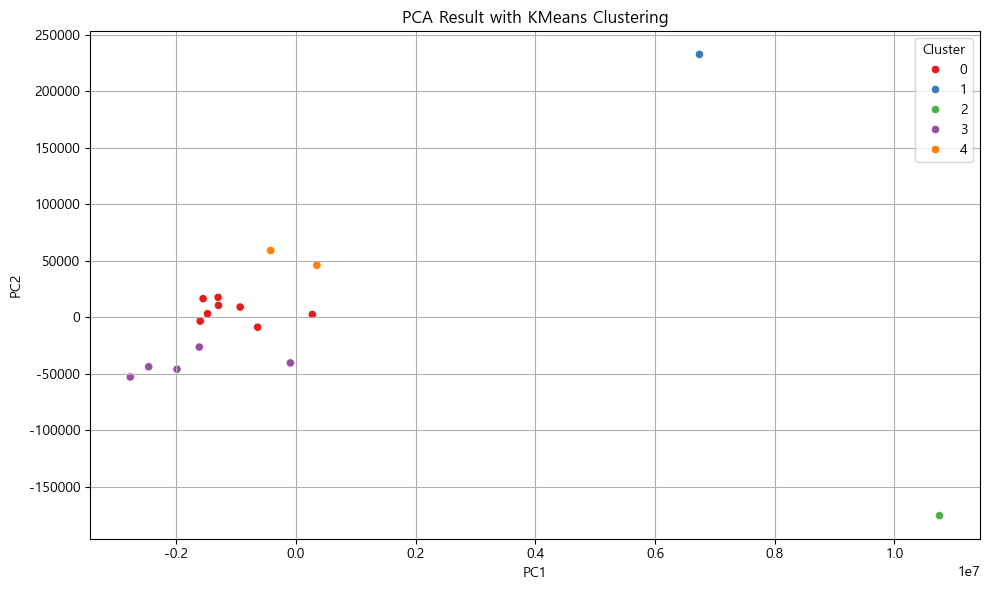

In [140]:
# KMeans 클러스터링 수행
kmeans = KMeans(n_clusters=cluster, random_state=42)
family_society_data['Cluster'] = kmeans.fit_predict(scaled_data)

# 클러스터링별 각 결과값 평균 groupby
groupby_df_kmeans = family_society_data.select_dtypes(['int', 'float']).groupby('Cluster').mean()

# 데이터 확인
display(groupby_df_kmeans)

# 클러스터 실루엣 계수와 다비에스-볼딘 지수 계산
silhouette_avg = silhouette_score(scaled_data, family_society_data['Cluster'])
db_score = davies_bouldin_score(scaled_data, family_society_data['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.3f}')
print(f'Davies-Bouldin Score: {db_score:.3f}')

# PCA 결과 시각화
pca_df['Cluster'] = family_society_data['Cluster']
plt.figure(figsize=(10, 6))
plt.title('PCA Result with KMeans Clustering')
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

,출생아수,교육기관수,어린이집수,초등학교수,영유아_인구수,아동_인구수,가구수,인구수,육아휴직(부),육아휴직(모)
Cluster,,,,,,,,,,
0,10185.740741,2.000000,432.481481,334.518519,78193.703704,132281.62963,8.907099e+05,2.002141e+06,359.259259,2516.962963
1,5202.166667,1.333333,168.083333,109.916667,39855.666667,66721.50000,3.697128e+05,8.668912e+05,215.333333,1440.000000
2,45192.666667,10.000000,790.000000,607.666667,309840.333333,491929.00000,4.042636e+06,9.016711e+06,1537.666667,14995.000000
3,76399.666667,5.666667,2196.666667,1311.666667,573996.000000,924719.00000,5.265352e+06,1.282443e+07,2558.666667,20366.000000
4,13311.166667,5.000000,545.500000,388.500000,102563.166667,169264.00000,1.289833e+06,2.832163e+06,440.000000,3423.500000


Silhouette Score: 0.434
Davies-Bouldin Score: 0.379


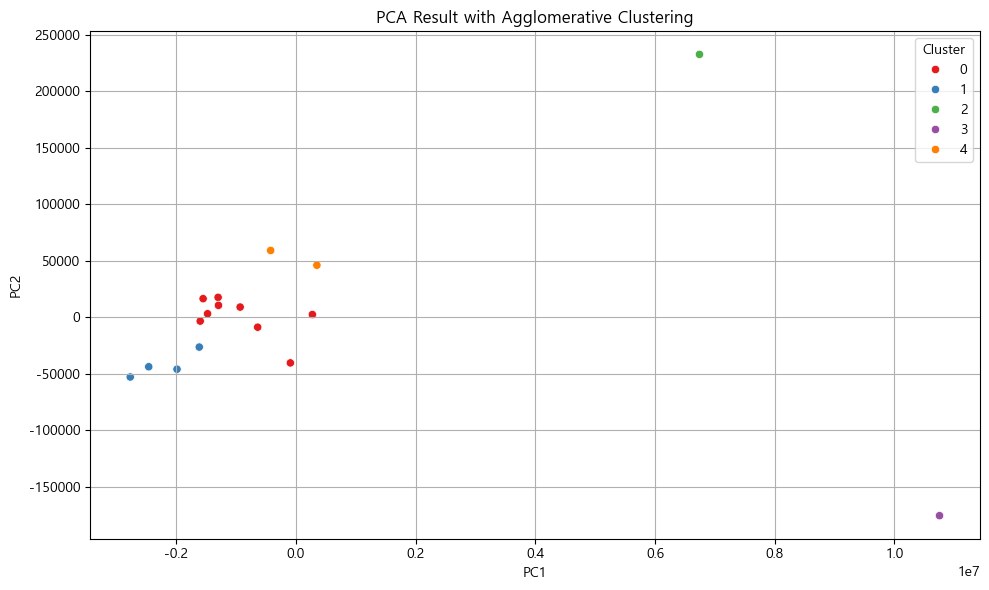

In [141]:
# Agglomerative Clustering 수행
Agg_cluster = AgglomerativeClustering(n_clusters=cluster)
family_society_data['Cluster'] = Agg_cluster.fit_predict(scaled_data)

# 클러스터링별 각 결과값 평균 groupby
groupby_df_agg = family_society_data.select_dtypes(['int', 'float']).groupby('Cluster').mean()

# 데이터 확인
display(groupby_df_agg)

# 클러스터 실루엣 계수와 다비에스-볼딘 지수 계산
silhouette_avg = silhouette_score(scaled_data, family_society_data['Cluster'])
db_score = davies_bouldin_score(scaled_data, family_society_data['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.3f}')
print(f'Davies-Bouldin Score: {db_score:.3f}')

# PCA 결과 시각화
pca_df['Cluster'] = family_society_data['Cluster']
plt.figure(figsize=(10, 6))
plt.title('PCA Result with Agglomerative Clustering')
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

,출생아수,교육기관수,어린이집수,초등학교수,영유아_인구수,아동_인구수,가구수,인구수,육아휴직(부),육아휴직(모)
Cluster,,,,,,,,,,
0,9565.166667,2.125000,436.583333,344.208333,73739.708333,125530.541667,8.544010e+05,1.900627e+06,336.000000,2365.000000
1,45192.666667,10.000000,790.000000,607.666667,309840.333333,491929.000000,4.042636e+06,9.016711e+06,1537.666667,14995.000000
2,76399.666667,5.666667,2196.666667,1311.666667,573996.000000,924719.000000,5.265352e+06,1.282443e+07,2558.666667,20366.000000
3,7191.800000,1.266667,214.400000,139.333333,54649.666667,90635.266667,5.320063e+05,1.256364e+06,281.333333,1898.533333
4,13311.166667,5.000000,545.500000,388.500000,102563.166667,169264.000000,1.289833e+06,2.832163e+06,440.000000,3423.500000


Silhouette Score: 0.449
Davies-Bouldin Score: 0.393


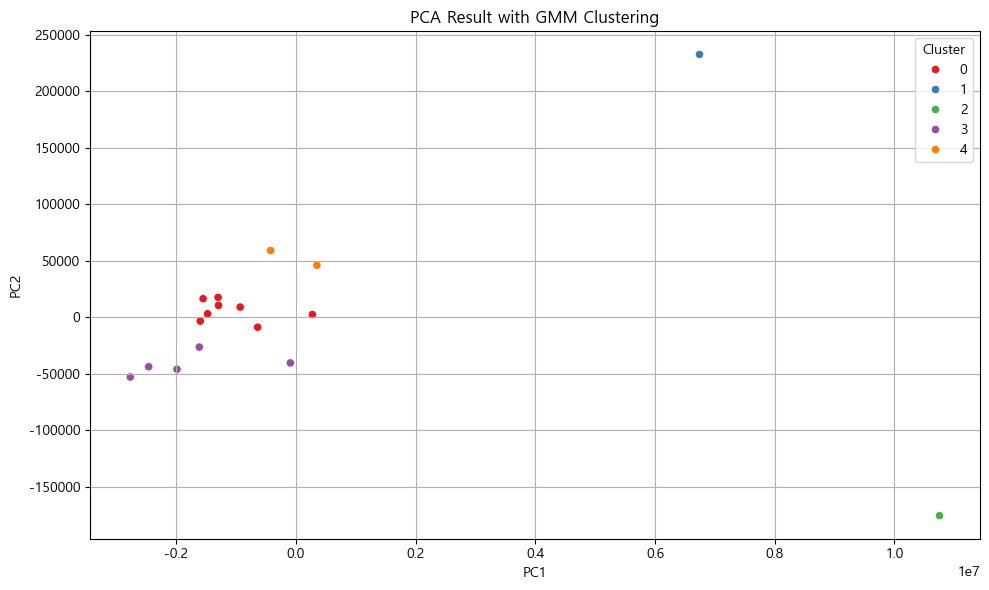

In [142]:
# GMM 클러스터링 수행
gmm = GaussianMixture(n_components=cluster, random_state=42)
family_society_data['Cluster'] = gmm.fit_predict(scaled_data)

# 클러스터링별 각 결과값 평균 groupby
groupby_df_gmm = family_society_data.select_dtypes(['int', 'float']).groupby('Cluster').mean()

# 데이터 확인
display(groupby_df_gmm)

# 클러스터 실루엣 계수와 다비에스-볼딘 지수 계산
silhouette_avg = silhouette_score(scaled_data, family_society_data['Cluster'])
db_score = davies_bouldin_score(scaled_data, family_society_data['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.3f}')
print(f'Davies-Bouldin Score: {db_score:.3f}')

# PCA 결과 시각화
pca_df['Cluster'] = family_society_data['Cluster']
plt.figure(figsize=(10, 6))
plt.title('PCA Result with GMM Clustering')
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [138]:
# 각 클러스터별 속하는 지역 확인
for i in range(cluster):
    print(f'Cluster {i} : {family_society_data[family_society_data['Cluster'] == i]['행정구역'].unique()}')

Cluster 0 : ['경상남도' '대구광역시' '인천광역시']
Cluster 1 : ['서울특별시']
Cluster 2 : ['경기도']
Cluster 3 : ['광주광역시' '세종특별자치시' '울산광역시' '제주특별자치도']
Cluster 4 : ['강원특별자치도' '대전광역시' '전라남도' '전북특별자치도' '충청남도' '충청북도']
Cluster 5 : ['경상북도' '부산광역시']
